<a href="https://colab.research.google.com/github/Elman295/Paper_with_code/blob/main/DCGAN_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torchvision 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import numpy as np 
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt

In [34]:
tfms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

training_data = datasets.CIFAR10(
    
    root = "data",
    download =True, 
    train = True, 
    transform = tfms
)


Files already downloaded and verified


In [35]:
train_dataloader = DataLoader(training_data, batch_size = 128, shuffle = True) 

In [36]:
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [37]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [38]:
images, targets = next(iter(train_dataloader))
print(images.shape)

torch.Size([128, 3, 32, 32])


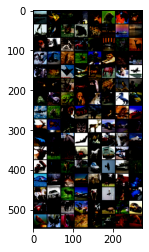

In [39]:
out = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(out,(1,2,0)))
plt.show()

In [40]:
def weight_init(m):
  classnames = m.__class__.__name__
  
  if classnames.find("Conv") != -1:
    nn.init.normal_(m.weight.data,0,0.02)
  elif classnames.find("BatchNorm") != -1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)


In [92]:


class Generator(nn.Module):

  def __init__(self): 
    super(Generator, self).__init__() 
    self.main = nn.Sequential(
        
        nn.ConvTranspose2d(100,512,4,1,0,bias = False), 
        nn.BatchNorm2d(512),
        nn.ReLU(inplace = True), 

        nn.ConvTranspose2d(512,256,4,2,1,bias = False), 
        nn.BatchNorm2d(256),
        nn.ReLU(inplace = True), 

        nn.ConvTranspose2d(256,128,4,2,1,bias = False), 
        nn.BatchNorm2d(128),
        nn.ReLU(inplace = True), 

        nn.ConvTranspose2d(128,3,4,2,1,bias = False),
        nn.Tanh()

    )

  def forward(self,x):
    x = self.main(x)
    return x

  

    




In [93]:
gen = Generator()
gen.to(device) 
gen.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [94]:
noise = torch.randn(size = (1,100,1,1)).to(device)
image = gen(noise)
print(image.shape)

torch.Size([1, 3, 32, 32])


In [95]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.main = nn.Sequential(
        

        nn.Conv2d(3,16,4,2,1,bias = False), 
        nn.BatchNorm2d(16),
        nn.LeakyReLU(0.2,inplace = True), 

        nn.Conv2d(16,64,4,2,1,bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,inplace = True), 

        nn.Conv2d(64,1,4,1,0,bias = False),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.main(x) 
    return x

In [96]:
dis = Discriminator()

dis.to(device)
dis.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [97]:
print(dis(image))

tensor([[[[0.7510, 0.5475, 0.5087, 0.7558, 0.5596],
          [0.3449, 0.5669, 0.4532, 0.5450, 0.4945],
          [0.5565, 0.6983, 0.4458, 0.7074, 0.7058],
          [0.4186, 0.4787, 0.6110, 0.6339, 0.5521],
          [0.6526, 0.7199, 0.5294, 0.6713, 0.6161]]]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


In [98]:
class Dis_loss(nn.Module):

  def __init__(self,gen,dis,base):
    super(Dis_loss,self).__init__()
    self.gen = gen
    self.dis = dis
    self.base = base

  def forward(self,noise,image):

    fake_loss = self.base(self.dis(self.gen(noise)),torch.zeros_like(self.dis(self.gen(noise))))
    real_loss = self.base(self.dis(image),torch.ones_like(self.dis(image)))
    loss = fake_loss + real_loss
    return loss

In [99]:
class Gen_loss(nn.Module):

  def __init__(self,gen,dis,base):
    super(Gen_loss,self).__init__()
    self.gen = gen
    self.base = base
    self.dis = dis 

  def forward(self,noise):
    loss_fake = self.base(self.dis(self.gen(noise)), torch.ones_like(self.dis(self.gen(noise))))
    return loss_fake

In [100]:
optim_gen = torch.optim.Adam(gen.parameters(), lr = 1e-3) 
optim_dis = torch.optim.Adam(dis.parameters(), lr = 1e-3) 

In [101]:
base = nn.BCELoss()

loss_dis = Dis_loss(gen,dis,base).to(device)
loss_gen = Gen_loss(gen,dis,base).to(device)

def train(dataloader, gen, dis, loss_gen, loss_dis,op_gen, op_dis):

  for batch, (image,label) in enumerate(dataloader):

    noise = torch.rand(size = (128,100,1,1),device = device) 
    image = image.to(device)
    loss_discriminator =  loss_dis(noise,image)
    op_dis.zero_grad()
    loss_discriminator.backward()
    op_dis.step() 


    loss_generator = loss_gen(noise)
    op_gen.zero_grad()
    loss_generator.backward()
    op_gen.step()

    if batch %100 == 0:

      print(f"genloss is {loss_generator.item()}")

In [102]:
seed = torch.randn(size =(16,100,1,1)).to(device)
img_list = []
def show_image(gen,seed):

  with torch.no_grad():
    images = gen(seed).detach()
    img_list.append(images)


In [103]:
print(img_list)

[]


In [104]:
for epoch in range(100):
  print(f"epoch {epoch+1}=-=-=-=-=-=-=-=-=-=-=-=")
  train(train_dataloader,gen,dis,loss_gen,loss_dis,optim_gen,optim_dis) 
  show_image(gen,seed) 

print("DONE")

epoch 1=-=-=-=-=-=-=-=-=-=-=-=
genloss is 0.8853555917739868
genloss is 1.1905536651611328
genloss is 2.152627468109131
genloss is 3.4702165126800537
epoch 2=-=-=-=-=-=-=-=-=-=-=-=
genloss is 3.6095409393310547
genloss is 4.622340202331543
genloss is 4.232936382293701
genloss is 4.631800651550293
epoch 3=-=-=-=-=-=-=-=-=-=-=-=
genloss is 4.323482990264893
genloss is 4.880129814147949
genloss is 4.852784156799316
genloss is 4.392450332641602
epoch 4=-=-=-=-=-=-=-=-=-=-=-=
genloss is 3.901879072189331
genloss is 3.658097982406616
genloss is 3.081150531768799
genloss is 2.8746776580810547
epoch 5=-=-=-=-=-=-=-=-=-=-=-=
genloss is 3.6700692176818848
genloss is 3.1071298122406006
genloss is 3.536229372024536
genloss is 3.1052584648132324
epoch 6=-=-=-=-=-=-=-=-=-=-=-=
genloss is 3.565924882888794
genloss is 3.161796808242798
genloss is 3.69113826751709
genloss is 3.5837647914886475
epoch 7=-=-=-=-=-=-=-=-=-=-=-=
genloss is 3.432748317718506
genloss is 4.006224632263184
genloss is 3.44299793

In [107]:
print(len(img_list))

100


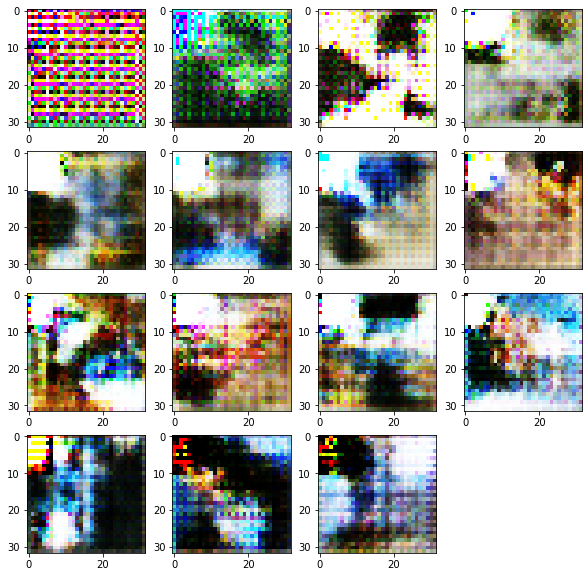

In [108]:
plt.figure(figsize = (10,10))
for i in range(1,16):
  plt.subplot(4,4,i)
  for j in range(0,16):
    plt.imshow(np.transpose(torchvision.utils.make_grid(img_list[i][j]*127.5 +127.5).cpu().numpy().astype("uint8"),(1,2,0)))
plt.show()